# Task 3: Baseline Model Comparison (Logistic Regression)

In this notebook, you will train a Logistic Regression model to predict the `prior_hiring_decision` target variable. You will also begin your fairness analysis by establishing a baseline for accuracy and fairness metrics.

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Load Data
train_df = pd.read_csv('../data/train.csv')
val_df = pd.read_csv('../data/val.csv')
test_df = pd.read_csv('../data/test.csv')

print("Training Shape:", train_df.shape)
print("Validation Shape:", val_df.shape)

Training Shape: (30000, 13)
Validation Shape: (10000, 13)


## 1. Feature Preprocessing
We will use all available features for this baseline model. 
- Categorical features will be One-Hot Encoded.
- Numerical features will be Scaled.

In [2]:
# Create Binary 'is_white' column for Fairness Evaluation (1 = White, 0 = Non-White)
train_df['is_white'] = (train_df['Race'] == 1).astype(int)
val_df['is_white'] = (val_df['Race'] == 1).astype(int)
test_df['is_white'] = (test_df['Race'] == 1).astype(int)

target = 'prior_hiring_decision'
sensitive_col = 'is_white'

# Features to DROP: Target + Sensitive Attributes + Proxies
# Note: 'Race' is the raw sensitive column, 'is_white' is our derived one. We drop both from training features.
drop_cols = [target, 'Race', 'is_white']

# Define Predictors list by excluding the drop_cols
features = [c for c in train_df.columns if c not in drop_cols]
print("Using Features:", features)

# Prepare X (features) and y (target)
X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

# CRITICAL: We Keep 'is_white' (sensitive_attribute) separate for the Fairness Evaluation later.
sensitive_val = val_df[sensitive_col]

# Identify Numerical vs Categorical columns for different preprocessing
# Explicitly define categorical columns since they are integer-encoded in ACS data
numerical_cols = ['Age', 'Hours_Per_Week', 'interview_score', 'cv_assessment_score']
categorical_cols = [c for c in features if c not in numerical_cols]

print("Numerical:", numerical_cols)
print("Categorical:", categorical_cols)

# Create the ColumnTransformer
# - Numerical: Standard Scaler (mean=0, var=1)
# - Categorical: One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

# Full Pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000))])

Using Features: ['Age', 'Workclass', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Hours_Per_Week', 'Sex', 'Place_Of_Birth', 'interview_score', 'cv_assessment_score']
Numerical: ['Age', 'Hours_Per_Week', 'interview_score', 'cv_assessment_score']
Categorical: ['Workclass', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Sex', 'Place_Of_Birth']


## 2. Model Training

In [3]:
X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

# Train
clf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

## 3. Evaluation (Accuracy)
Report the accuracy on the validation set.

In [4]:
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Validation Accuracy: 0.7316
Confusion Matrix:
[[3924 1275]
 [1409 3392]]


## 4. Fairness Metric Implementation
**TODO:** Select your fairness metric (Demographic Parity, Equal Opportunity, or Equalized Odds) and calculate it for this model. You should compare the metric across different groups (e.g., Race).

In [5]:
# TODO: Implement fairness metric calculation here
# ============================================================
# Lecture 2 aligned fairness metrics for binary sensitive attribute A=is_white
# y_true: prior_hiring_decision (0/1)
# y_pred: model predictions (0/1)
# A:      is_white (0/1)
#
# Metrics:
#   - Demographic Parity (DP):    P(Ŷ=1 | A=a)  (slide ~30)
#   - Equalized Opportunity (EO): P(Ŷ=1 | Y=1, A=a)  (slide ~34) == TPR parity
#   - Equalized Odds (EOD):       EO + FPR parity    (slide ~36)
# ============================================================
import importlib
import utils
importlib.reload(utils)
from utils import fairness_metrics

fairness_results, fairness_gaps = fairness_metrics(y_val, y_pred, sensitive_val, min_group_size=30)
print("Validation Accuracy:", acc)
for group, result in fairness_results.items():
    print(f"Group {group}")
    for metric, value in result.items():
        print(f"  {metric}: {value}")
for metric, gap in fairness_gaps.items():
    print(f"{metric} Gap: {gap}")

Validation Accuracy: 0.7316
Group 0
  n: 3756
  selection_rate_P(yhat=1|A): 0.3282747603833866
  TPR_P(yhat=1|Y=1,A): 0.5958023019634394
  FPR_P(yhat=1|Y=0,A): 0.15489249670908292
  TNR: 0.8451075032909171
  FNR: 0.4041976980365606
  TP: 880
  FP: 353
  TN: 1926
  FN: 597
Group 1
  n: 6244
  selection_rate_P(yhat=1|A): 0.5499679692504804
  TPR_P(yhat=1|Y=1,A): 0.7557160048134778
  FPR_P(yhat=1|Y=0,A): 0.31575342465753425
  TNR: 0.6842465753424658
  FNR: 0.24428399518652227
  TP: 2512
  FP: 922
  TN: 1998
  FN: 812
DP_gap_|P(yhat=1|A=1)-P(yhat=1|A=0)| Gap: 0.22169320886709382
EO_gap_|TPR(A=1)-TPR(A=0)| Gap: 0.15991370285003836
FPR_gap_|FPR(A=1)-FPR(A=0)| Gap: 0.16086092794845133
EOD_gap_max(TPR_gap,FPR_gap) Gap: 0.16086092794845133


## 5. ROC Curve Analysis
**TODO:** Plot the ROC Curve for this model on the validation set and calculate the AUC. Discuss what this tells you about the model's ability to distinguish classes at different thresholds.

In [6]:
y_pred_proba = clf.predict_proba(X_val)[:, 1]

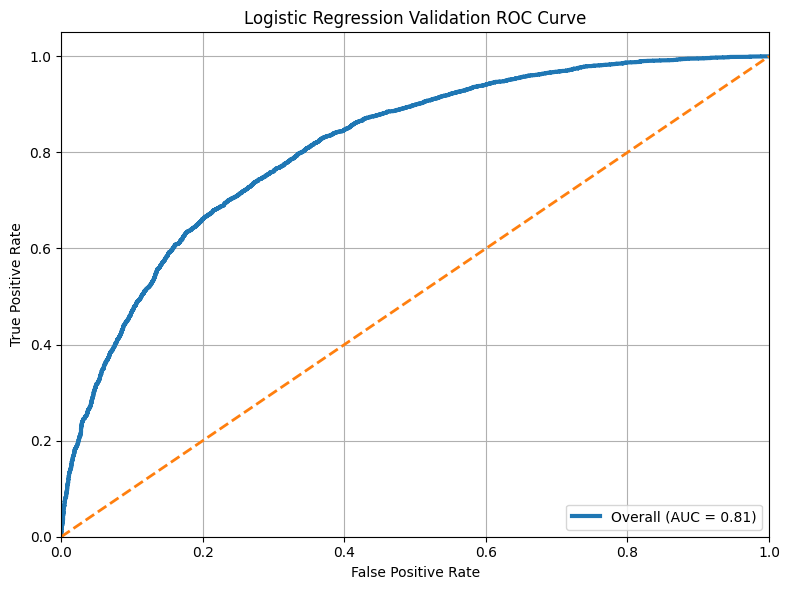

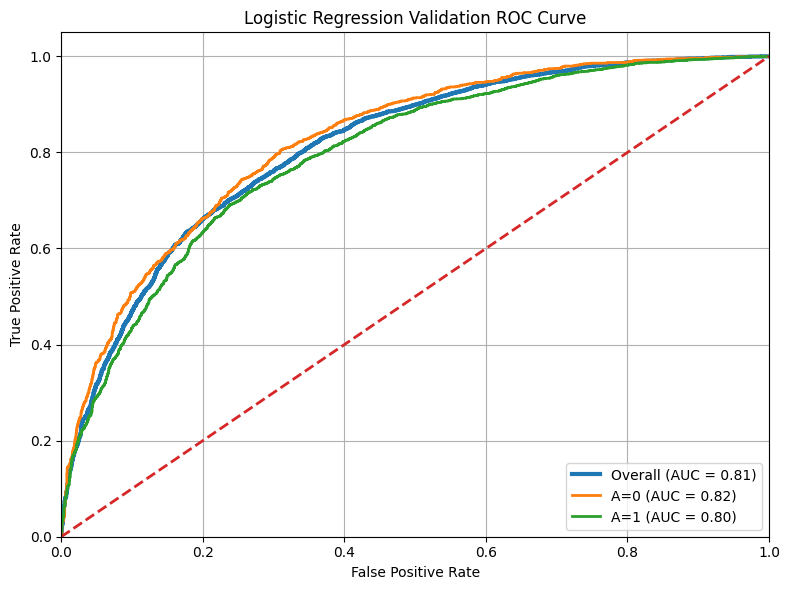

In [7]:
importlib.reload(utils)
from utils import plot_roc_curve
plot_roc_curve(y_val, y_pred_proba, title="Logistic Regression Validation ROC Curve")
plot_roc_curve(y_val, y_pred_proba, sensitive_val, title="Logistic Regression Validation ROC Curve")